In [53]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import os
from dotenv import load_dotenv

In [54]:
pd.set_option("display.max_columns", None)
load_dotenv(dotenv_path=".env")
gemini_api_key = os.getenv("GOOGLE_API_KEY")

In [55]:
quiz_data = requests.get("https://www.jsonkeeper.com/b/LLQT").json()
quiz_submission = requests.get("https://api.jsonserve.com/rJvd7g").json()
last_quizes = requests.get("https://api.jsonserve.com/XgAgFJ").json()

In [56]:
import google.generativeai as genai
genai.configure(api_key=gemini_api_key)
model = genai.GenerativeModel("gemini-2.0-flash")

#  Task 1: Analyze the Data:
- #### Explore the schema and identify patterns in student performance by topics, difficulty levels, and response accuracy.

In [57]:
current_quiz_df = pd.DataFrame([quiz_data['quiz']])
print(current_quiz_df.info())
current_quiz_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1 non-null      int64 
 1   name                  0 non-null      object
 2   title                 1 non-null      object
 3   description           1 non-null      object
 4   difficulty_level      0 non-null      object
 5   topic                 1 non-null      object
 6   time                  1 non-null      object
 7   is_published          1 non-null      bool  
 8   created_at            1 non-null      object
 9   updated_at            1 non-null      object
 10  duration              1 non-null      int64 
 11  end_time              1 non-null      object
 12  negative_marks        1 non-null      object
 13  correct_answer_marks  1 non-null      object
 14  shuffle               1 non-null      bool  
 15  show_answers          1 non-null      bool  

,id,name,title,description,difficulty_level,topic,time,is_published,created_at,updated_at,duration,end_time,negative_marks,correct_answer_marks,shuffle,show_answers,lock_solutions,is_form,show_mastery_option,quiz_type,is_custom,banner_id,exam_id,show_unanswered,ends_at,lives,live_count,coin_count,questions_count,daily_date,max_mistake_count,questions
0,43,None,Structural Organisation in Animals and Plants (7),,None,Structural Organisation in Animals,2024-07-03T00:00:00.000+05:30,True,2024-07-03T11:00:08.958+05:30,2024-09-23T18:43:27.751+05:30,128,2024-07-04T00:00:00.000+05:30,1.0,4.0,True,True,False,False,False,None,False,None,None,False,2025-01-18,None,Free Test,-1,128,"January 17, 2025",15,"[{'id': 1827, 'description': 'The tissue which..."


In [58]:
current_quiz_questions_df = pd.DataFrame(quiz_data['quiz']['questions'])
print(current_quiz_questions_df.info())
current_quiz_questions_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   128 non-null    int64 
 1   description          128 non-null    object
 2   difficulty_level     0 non-null      object
 3   topic                128 non-null    object
 4   is_published         128 non-null    bool  
 5   created_at           128 non-null    object
 6   updated_at           128 non-null    object
 7   detailed_solution    119 non-null    object
 8   type                 63 non-null     object
 9   is_mandatory         128 non-null    bool  
 10  show_in_feed         128 non-null    bool  
 11  pyq_label            5 non-null      object
 12  topic_id             128 non-null    int64 
 13  reading_material_id  128 non-null    int64 
 14  fixed_at             5 non-null      object
 15  fix_summary          5 non-null      object
 16  created_

,id,description,difficulty_level,topic,is_published,created_at,updated_at,detailed_solution,type,is_mandatory,show_in_feed,pyq_label,topic_id,reading_material_id,fixed_at,fix_summary,created_by,updated_by,quiz_level,question_from,language,photo_url,photo_solution_url,is_saved,tag,options
0,1827,The tissue which has free surface that faces e...,None,structural organisation in animals,True,2024-07-02T12:43:34.360+05:30,2024-11-30T18:39:20.587+05:30,**Explanation:**\n\nThe tissue that has a free...,,False,False,None,146,2016,None,None,None,None,None,Q-bank,None,None,None,False,,"[{'id': 7321, 'description': 'Muscular tissue'..."
1,1828,Epithelial tissue is distinguished from connec...,None,structural organisation in animals,True,2024-07-02T12:50:56.100+05:30,2024-11-30T18:39:20.788+05:30,**Epithelial Tissue**\n\n* Epithelial tissue i...,,False,False,None,146,2017,None,None,None,None,None,Q-bank,None,None,None,False,,"[{'id': 7325, 'description': 'large extracellu..."
2,1829,The ciliated columnar epithelial cells in huma...,None,structural organisation in animals,True,2024-07-02T12:54:25.824+05:30,2024-11-30T18:39:20.990+05:30,**Explanation:**\n\nCiliated columnar epitheli...,,False,False,None,146,2018,None,None,None,None,None,Q-bank,None,None,None,False,,"[{'id': 7329, 'description': 'Eustachian tube ..."
3,1830,The squamous epithelium is found in,None,structural organisation in animals,True,2024-07-02T12:56:48.204+05:30,2024-11-30T18:39:21.192+05:30,**Explanation:**\n\nSquamous epithelium is a t...,,False,False,None,146,2019,None,None,None,None,None,Q-bank,None,None,None,False,,"[{'id': 7333, 'description': 'stomach', 'quest..."
4,1831,The kind of epithelium which forms the inner w...,None,structural organisation in animals,True,2024-07-02T12:58:51.241+05:30,2024-11-30T18:39:21.398+05:30,**Answer is correct because:**\n\nSquamous epi...,,False,False,None,146,2020,None,None,None,None,None,Q-bank,None,None,None,False,,"[{'id': 7337, 'description': 'cuboidal epithel..."


In [59]:
current_quiz_submission_df = pd.DataFrame([quiz_submission])
current_quiz_submission_df

,id,quiz_id,user_id,submitted_at,created_at,updated_at,score,trophy_level,accuracy,speed,final_score,negative_score,correct_answers,incorrect_answers,source,type,started_at,ended_at,duration,better_than,total_questions,rank_text,mistakes_corrected,initial_mistake_count,response_map,quiz,next_steps
0,336566,43,7ZXdz3zHuNcdg9agb5YpaOGLQqw2,2025-01-17T15:51:29.859+05:30,2025-01-17T15:51:29.871+05:30,2025-01-17T15:51:29.871+05:30,32,2,80 %,100,30.0,2.0,8,2,live,topic,2025-01-17T16:20:44.000+05:30,2025-01-17T16:21:28.000+05:30,15:00,24,128,Topic Rank - #2402,6,8,"{'1837': 7363, '1848': 7407, '1852': 7423, '18...","{'id': 43, 'name': None, 'title': 'Structural ...",[{'pageType': 'resultPage'}]


In [60]:
last_quizes_df = pd.DataFrame(last_quizes)
last_quizes_df = pd.concat([last_quizes_df, current_quiz_submission_df], ignore_index=True)
print(last_quizes_df.info())
last_quizes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     15 non-null     int64 
 1   quiz_id                15 non-null     int64 
 2   user_id                15 non-null     object
 3   submitted_at           15 non-null     object
 4   created_at             15 non-null     object
 5   updated_at             15 non-null     object
 6   score                  15 non-null     int64 
 7   trophy_level           15 non-null     int64 
 8   accuracy               15 non-null     object
 9   speed                  15 non-null     object
 10  final_score            15 non-null     object
 11  negative_score         15 non-null     object
 12  correct_answers        15 non-null     int64 
 13  incorrect_answers      15 non-null     int64 
 14  source                 15 non-null     object
 15  type                   15

,id,quiz_id,user_id,submitted_at,created_at,updated_at,score,trophy_level,accuracy,speed,final_score,negative_score,correct_answers,incorrect_answers,source,type,started_at,ended_at,duration,better_than,total_questions,rank_text,mistakes_corrected,initial_mistake_count,response_map,quiz,next_steps
0,336497,51,YcDFSO4ZukTJnnFMgRNVwZTE4j42,2025-01-17T15:30:18.027+05:30,2025-01-17T15:30:18.044+05:30,2025-01-17T15:30:18.044+05:30,108,2,90 %,100,105.0,3.0,27,3,exam,topic,2025-01-17T15:18:30.000+05:30,2025-01-17T15:30:15.000+05:30,15:00,107,100,Topic Rank - #-171,9,12,"{'2523': 10109, '2529': 10130, '2533': 10149, ...","{'id': 51, 'name': None, 'title': 'Human Physi...",NaN
1,336448,6,YcDFSO4ZukTJnnFMgRNVwZTE4j42,2025-01-17T15:17:44.042+05:30,2025-01-17T15:17:44.056+05:30,2025-01-17T15:17:44.056+05:30,92,1,100 %,100,92.0,0.0,23,0,exam,topic,2025-01-17T15:07:45.000+05:30,2025-01-17T15:17:41.000+05:30,15:00,395,23,Topic Rank - #-9140,3,3,"{'48': 192, '49': 197, '50': 199, '51': 203, '...","{'id': 6, 'name': None, 'title': 'Human Physio...",NaN
2,333330,51,YcDFSO4ZukTJnnFMgRNVwZTE4j42,2025-01-16T20:13:19.682+05:30,2025-01-16T20:13:19.699+05:30,2025-01-16T20:13:19.699+05:30,116,2,96 %,100,115.0,1.0,29,1,live,topic,2025-01-16T20:01:10.000+05:30,2025-01-16T20:13:18.000+05:30,15:00,115,100,Topic Rank - #-418,11,12,"{'2523': 10109, '2525': 10117, '2528': 10127, ...","{'id': 51, 'name': None, 'title': 'Human Physi...",NaN
3,333242,6,YcDFSO4ZukTJnnFMgRNVwZTE4j42,2025-01-16T20:00:11.562+05:30,2025-01-16T20:00:11.573+05:30,2025-01-16T20:00:11.573+05:30,36,2,90 %,100,35.0,1.0,9,1,live,topic,2025-01-16T19:52:57.000+05:30,2025-01-16T20:00:09.000+05:30,15:00,152,23,Topic Rank - #-1598,1,2,"{'49': 197, '52': 208, '53': 212, '54': 217, '...","{'id': 6, 'name': None, 'title': 'Human Physio...",NaN
4,329504,51,YcDFSO4ZukTJnnFMgRNVwZTE4j42,2025-01-15T20:34:39.462+05:30,2025-01-15T20:34:39.478+05:30,2025-01-15T20:34:39.478+05:30,36,3,31 %,96,16.0,20.0,9,20,exam,topic,2025-01-15T20:21:25.000+05:30,2025-01-15T20:34:38.000+05:30,15:00,35,100,Topic Rank - #2023,0,20,"{'2521': 10099, '2523': 10107, '2532': 10145, ...","{'id': 51, 'name': None, 'title': 'Human Physi...",NaN


### Analysing and plotting trends in topics over time

In [61]:
from datetime import datetime
import pandas as pd

topics = {}

for _, row in last_quizes_df.iterrows():
    quiz_id = row['quiz']['id']
    topic = row['quiz']['topic'].strip().lower()
    submitted_at = pd.to_datetime(row['submitted_at'])
    speed = row['speed']

    if topic not in topics:
        topics[topic] = []

    topics[topic].append({
        "quiz_id": quiz_id,
        "submitted_at": submitted_at,
        "total_questions": row["total_questions"],
        "correct_answers": row["correct_answers"],
        "incorrect_answers": row["incorrect_answers"],
        "speed": row['speed']
    })

for topic in topics:
    topics[topic] = sorted(topics[topic], key=lambda x: x["submitted_at"])
print(topics)

{'body fluids and circulation': [{'quiz_id': 6, 'submitted_at': Timestamp('2025-01-15 15:36:46.410000+0530', tz='UTC+05:30'), 'total_questions': 23, 'correct_answers': 9, 'incorrect_answers': 9, 'speed': '78'}, {'quiz_id': 51, 'submitted_at': Timestamp('2025-01-15 20:34:39.462000+0530', tz='UTC+05:30'), 'total_questions': 100, 'correct_answers': 9, 'incorrect_answers': 20, 'speed': '96'}, {'quiz_id': 6, 'submitted_at': Timestamp('2025-01-16 20:00:11.562000+0530', tz='UTC+05:30'), 'total_questions': 23, 'correct_answers': 9, 'incorrect_answers': 1, 'speed': '100'}, {'quiz_id': 51, 'submitted_at': Timestamp('2025-01-16 20:13:19.682000+0530', tz='UTC+05:30'), 'total_questions': 100, 'correct_answers': 29, 'incorrect_answers': 1, 'speed': '100'}, {'quiz_id': 6, 'submitted_at': Timestamp('2025-01-17 15:17:44.042000+0530', tz='UTC+05:30'), 'total_questions': 23, 'correct_answers': 23, 'incorrect_answers': 0, 'speed': '100'}, {'quiz_id': 51, 'submitted_at': Timestamp('2025-01-17 15:30:18.0270

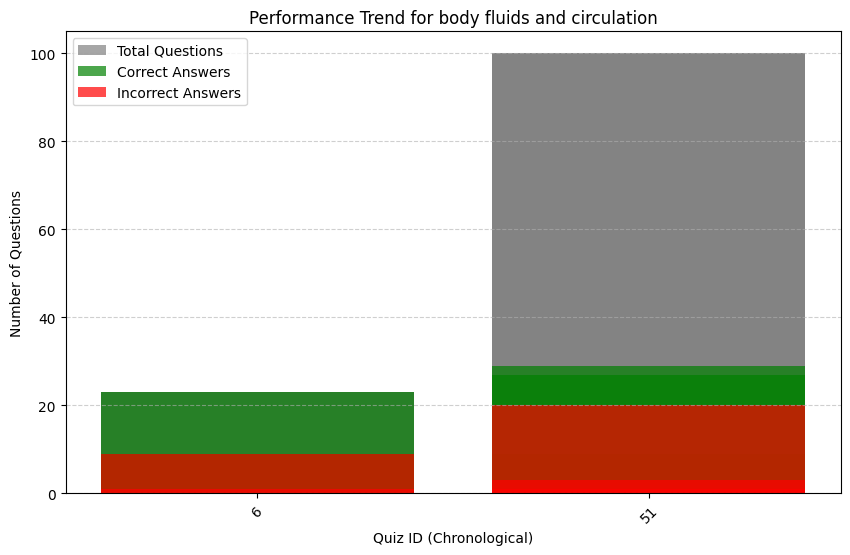

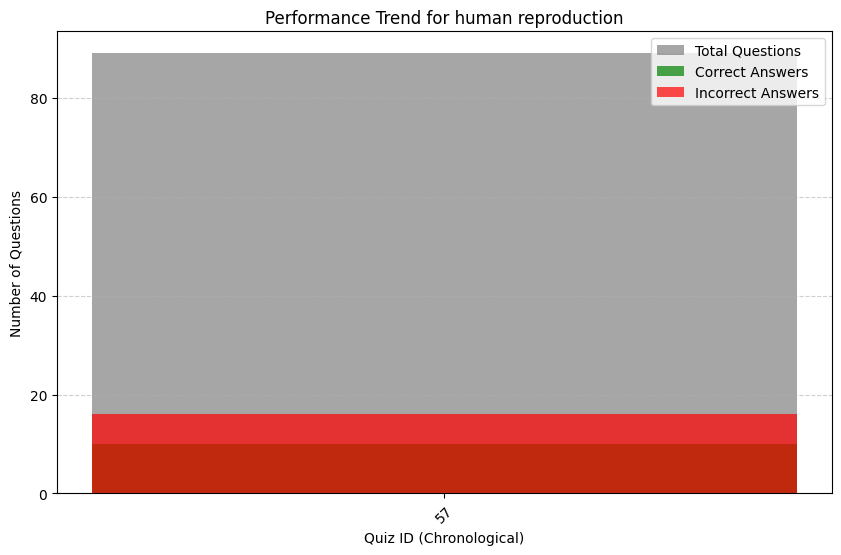

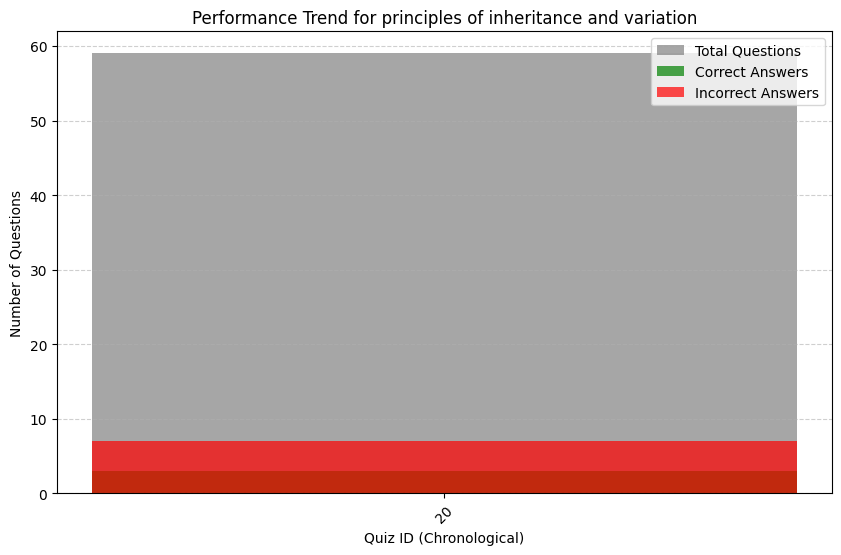

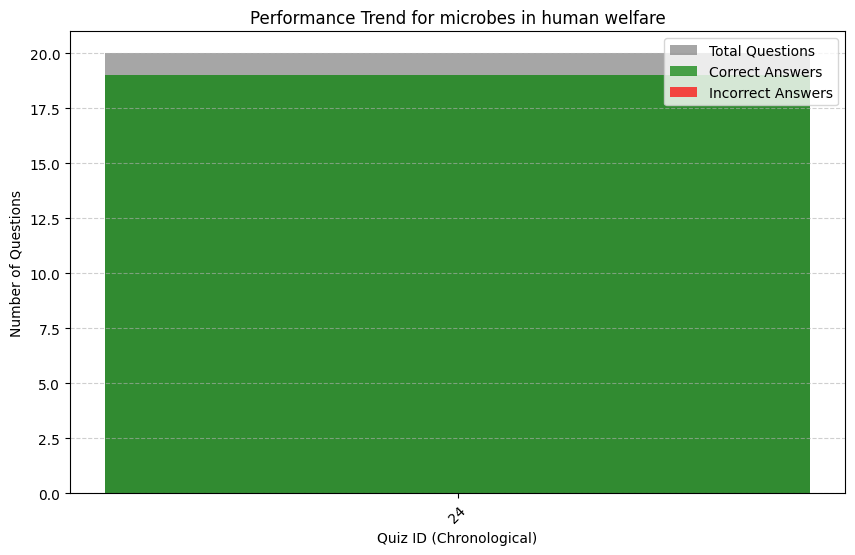

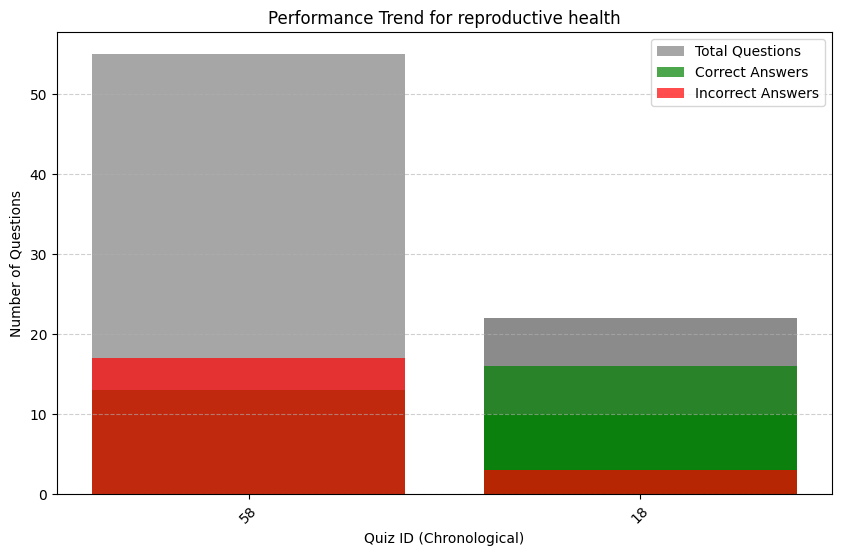

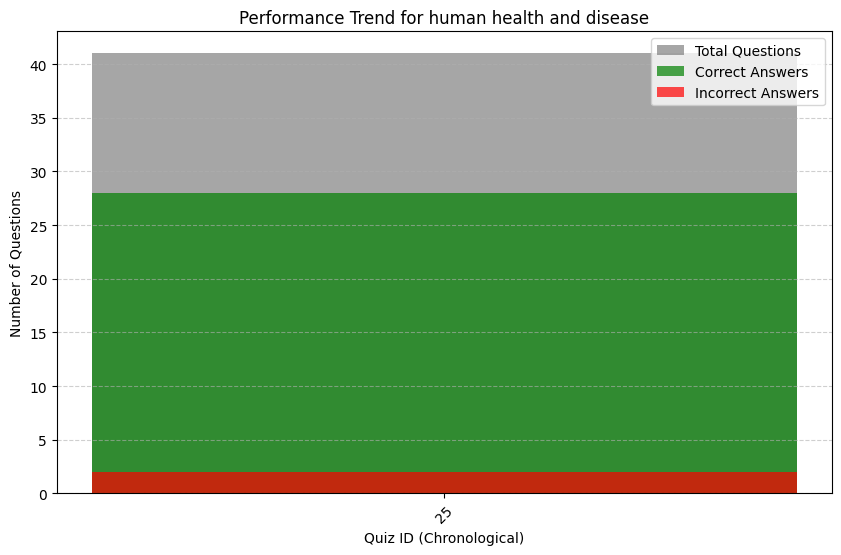

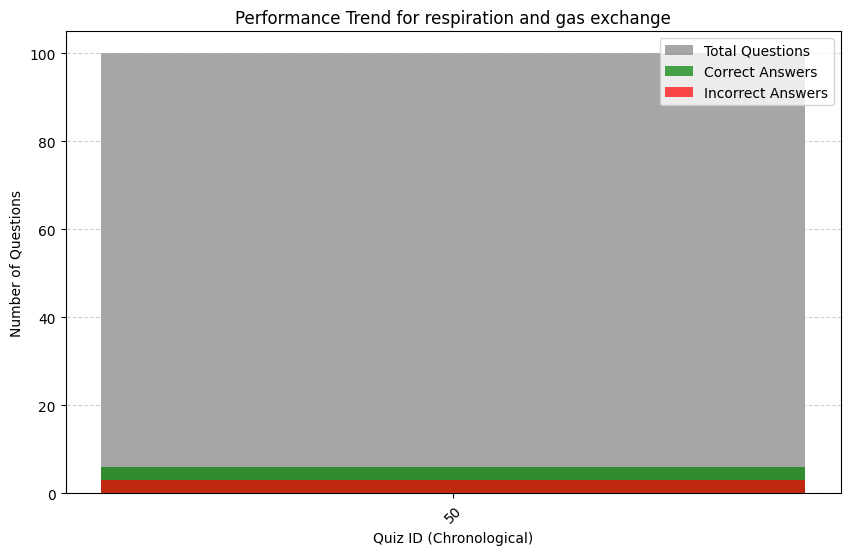

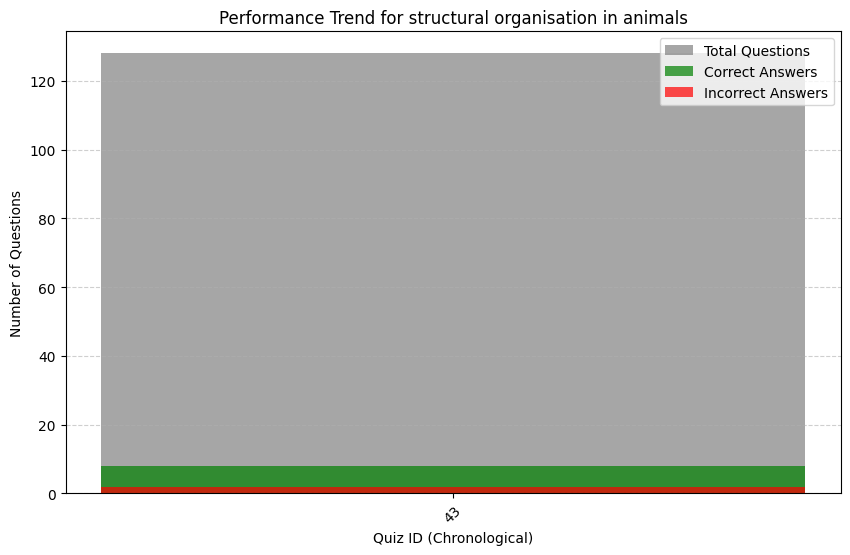

In [62]:
import matplotlib.pyplot as plt

for topic, quizzes in topics.items():
    quiz_ids = [str(q["quiz_id"]) for q in quizzes]
    total_questions = [q["total_questions"] for q in quizzes]
    correct_answers = [q["correct_answers"] for q in quizzes]
    incorrect_answers = [q["incorrect_answers"] for q in quizzes]

    plt.figure(figsize=(10, 6))
    plt.bar(quiz_ids, total_questions, color="gray", label="Total Questions", alpha=0.7)
    plt.bar(quiz_ids, correct_answers, color="green", label="Correct Answers", alpha=0.7)
    plt.bar(quiz_ids, incorrect_answers, color="red", label="Incorrect Answers", alpha=0.7)

    plt.xlabel("Quiz ID (Chronological)")
    plt.ylabel("Number of Questions")
    plt.title(f"Performance Trend for {topic}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()


In [63]:
from datetime import datetime
import pandas as pd

difficulty = {}

for _, row in last_quizes_df.iterrows():
    quiz_id = row['quiz']['id']
    difficulty_level = row['quiz']['difficulty_level']
    submitted_at = pd.to_datetime(row['submitted_at'])
    speed = row['speed']

    if difficulty_level not in difficulty:
        difficulty[difficulty_level] = []

    difficulty[difficulty_level].append({
        "quiz_id": quiz_id,
        "submitted_at": submitted_at,
        "total_questions": row["total_questions"],
        "correct_answers": row["correct_answers"],
        "incorrect_answers": row["incorrect_answers"],
        "speed": row['speed']
    })

for difficulty_level in difficulty:
    difficulty[difficulty_level] = sorted(difficulty[difficulty_level], key=lambda x: x["submitted_at"])
print(difficulty)

{None: [{'quiz_id': 50, 'submitted_at': Timestamp('2024-12-11 20:36:44.822000+0530', tz='UTC+05:30'), 'total_questions': 100, 'correct_answers': 6, 'incorrect_answers': 3, 'speed': '90'}, {'quiz_id': 58, 'submitted_at': Timestamp('2024-12-28 22:58:52.969000+0530', tz='UTC+05:30'), 'total_questions': 55, 'correct_answers': 13, 'incorrect_answers': 17, 'speed': '100'}, {'quiz_id': 18, 'submitted_at': Timestamp('2025-01-11 21:03:43.251000+0530', tz='UTC+05:30'), 'total_questions': 22, 'correct_answers': 16, 'incorrect_answers': 3, 'speed': '86'}, {'quiz_id': 25, 'submitted_at': Timestamp('2025-01-11 21:20:08.641000+0530', tz='UTC+05:30'), 'total_questions': 41, 'correct_answers': 28, 'incorrect_answers': 2, 'speed': '100'}, {'quiz_id': 18, 'submitted_at': Timestamp('2025-01-13 13:12:40.687000+0530', tz='UTC+05:30'), 'total_questions': 22, 'correct_answers': 10, 'incorrect_answers': 0, 'speed': '100'}, {'quiz_id': 24, 'submitted_at': Timestamp('2025-01-13 13:28:12.784000+0530', tz='UTC+05:

### Analysing and plotting trends in difficulty_level over time
the difficulty level have all values as None so analyzing this is not useful

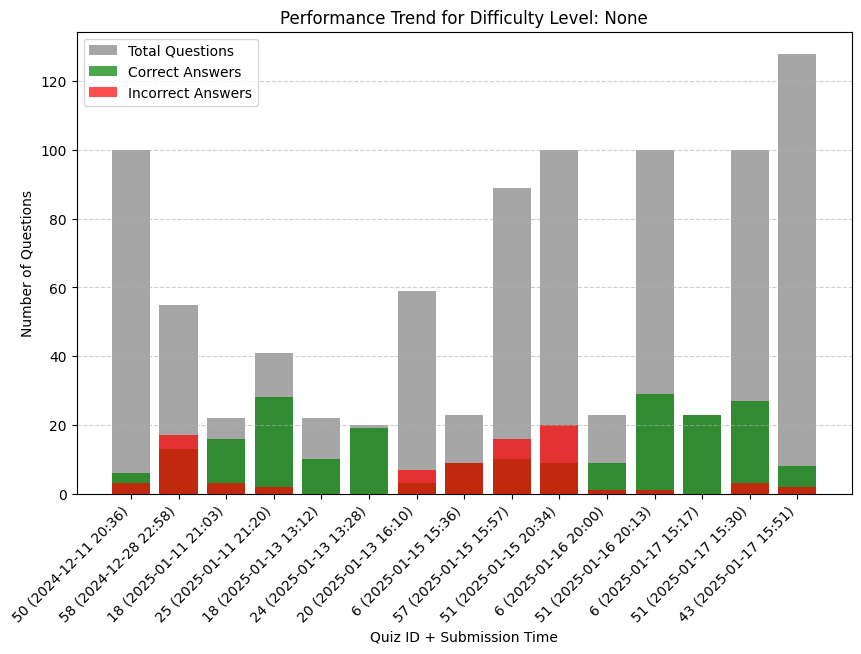

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

for difficulty_level, quizzes in difficulty.items():
    quizzes = sorted(quizzes, key=lambda q: q["submitted_at"])

    quiz_labels = [f"{q['quiz_id']} ({q['submitted_at'].strftime('%Y-%m-%d %H:%M')})" for q in quizzes]
    total_questions = [q["total_questions"] for q in quizzes]
    correct_answers = [q["correct_answers"] for q in quizzes]
    incorrect_answers = [q["incorrect_answers"] for q in quizzes]

    plt.figure(figsize=(10, 6))
    plt.bar(quiz_labels, total_questions, color="gray", label="Total Questions", alpha=0.7)
    plt.bar(quiz_labels, correct_answers, color="green", label="Correct Answers", alpha=0.7)
    plt.bar(quiz_labels, incorrect_answers, color="red", label="Incorrect Answers", alpha=0.7)

    plt.xlabel("Quiz ID + Submission Time")
    plt.ylabel("Number of Questions")
    plt.title(f"Performance Trend for Difficulty Level: {difficulty_level}")
    plt.xticks(rotation=45, ha="right") 
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.show()


### Analysing and plotting trends in accuracy over time

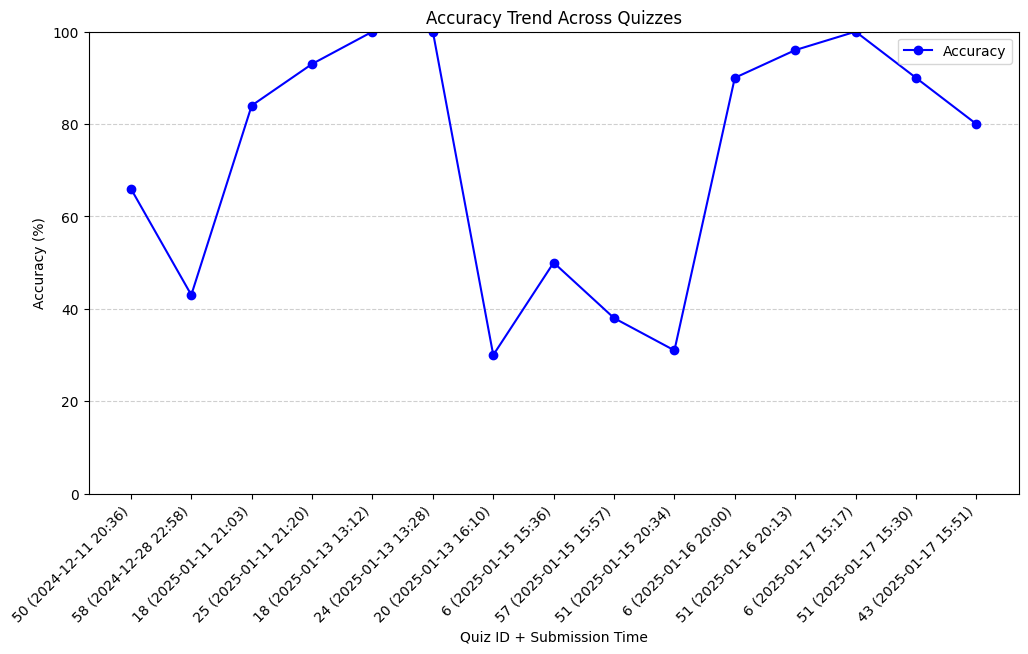

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

last_quizes_df["submitted_at"] = pd.to_datetime(last_quizes_df["submitted_at"])
last_quizes_df["accuracy"] = last_quizes_df["accuracy"].str.rstrip(" %").astype(float)

sorted_df = last_quizes_df.sort_values(by="submitted_at")

sorted_df["quiz_label"] = sorted_df["quiz_id"].astype(str) + " (" + sorted_df["submitted_at"].dt.strftime("%Y-%m-%d %H:%M") + ")"

quiz_labels = sorted_df["quiz_label"]
accuracies = sorted_df["accuracy"]

plt.figure(figsize=(12, 6))
plt.plot(quiz_labels, accuracies, marker="o", linestyle="-", color="blue", label="Accuracy")

plt.xlabel("Quiz ID + Submission Time")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Trend Across Quizzes")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


# Task 2: Generate Insights:
- #### Highlight weak areas, improvement trends, and performance gaps for a given user.

In [66]:
import pandas as pd
import numpy as np

topic_stats = {}

for _, row in last_quizes_df.iterrows():
    topic = row["quiz"]["topic"].strip().lower()
    submitted_at = pd.to_datetime(row["submitted_at"])
    accuracy = row["accuracy"]
    quiz_id = row["quiz"]["id"]

    if topic not in topic_stats:
        topic_stats[topic] = []

    topic_stats[topic].append({
        "quiz_id": quiz_id,
        "submitted_at": submitted_at,
        "accuracy": accuracy
    })

for topic in topic_stats:
    topic_stats[topic] = sorted(topic_stats[topic], key=lambda x: x["submitted_at"])

weak_areas = []
improving_topics = []
fluctuating_topics = []

for topic, quizzes in topic_stats.items():
    accuracies = [q["accuracy"] for q in quizzes]
    
    avg_accuracy = np.mean(accuracies)
    if avg_accuracy < 50:
        weak_areas.append((topic, avg_accuracy))

    if len(accuracies) > 1 and accuracies[-1] > accuracies[0]:
        improving_topics.append((topic, accuracies[0], accuracies[-1]))

    if len(accuracies) > 1 and max(accuracies) - min(accuracies) > 30:
        fluctuating_topics.append((topic, min(accuracies), max(accuracies)))

print("\n🔴 Weak Areas (Avg Accuracy < 50%):")
for topic, acc in weak_areas:
    print(f"  - {topic}: {acc:.2f}% avg accuracy")

print("\n🟢 Improving Topics (First vs Last Accuracy):")
for topic, start, end in improving_topics:
    print(f"  - {topic}: {start:.2f}% ➝ {end:.2f}%")

print("\n🟡 Fluctuating Topics (Large Accuracy Variations):")
for topic, min_acc, max_acc in fluctuating_topics:
    print(f"  - {topic}: {min_acc:.2f}% ↔ {max_acc:.2f}%")



🔴 Weak Areas (Avg Accuracy < 50%):
  - human reproduction: 38.00% avg accuracy
  - principles of inheritance and variation: 30.00% avg accuracy

🟢 Improving Topics (First vs Last Accuracy):
  - body fluids and circulation: 50.00% ➝ 90.00%
  - reproductive health: 43.00% ➝ 100.00%

🟡 Fluctuating Topics (Large Accuracy Variations):
  - body fluids and circulation: 31.00% ↔ 100.00%
  - reproductive health: 43.00% ↔ 100.00%


# Task 3: Create Recommendations:
- #### Propose actionable steps for the user to improve, such as suggested topics, question types, or difficulty levels to focus on.

In [67]:
def extract_topic_performance(topics_dict):
    """
    Extracts summarized performance data from topic-wise quiz history.
    
    :param topics_dict: Dictionary containing quiz performance data for each topic.
    :return: Dictionary with aggregated data per topic.
    """
    topic_summary = {}

    for topic, quizzes in topics_dict.items():
        total_attempted = sum(q["total_questions"] for q in quizzes)
        total_correct = sum(q["correct_answers"] for q in quizzes)
        total_incorrect = sum(q["incorrect_answers"] for q in quizzes)
        speed = sum(int(q["speed"]) for q in quizzes)

        topic_summary[topic] = {
            "total_attempted": total_attempted,
            "correct": total_correct,
            "incorrect": total_incorrect,
            "speed": speed
        }

    return topic_summary


def generate_performance_prompt(topics_dict):
    topic_data = extract_topic_performance(topics_dict)

    topic_details = "\n".join([
        f"- **{topic.capitalize()}**: Attempted: {data['total_attempted']}, Correct: {data['correct']}, "
        f"Incorrect: {data['incorrect']}, speed: {data['speed']}%" 
        for topic, data in topic_data.items()
    ])

    prompt = f"""
    You are an AI tutor analyzing a student's quiz performance. Below is the student's topic-wise performance data:

    {topic_details}

    **Task:**
        Identify topics where accuracy is **below 50%** (weak areas).
        Highlight topics showing **improvement trends** over time.
        Detect **fluctuating performance** (if accuracy varies by more than 30% across quizzes).
        Provide actionable recommendations:
       - **Key topics** to focus on
       - **Suggested question types** (conceptual, formula-based, application-based)
       - **Time management strategies**
       - **Study techniques & resources**
    
    Use a **motivational and structured** tone to guide the student. The insights should be **practical and easy to follow. Also leep it under 100 words**.
    """
    response = model.generate_content(prompt)
    return response.text


performance = generate_performance_prompt(topics)
print(performance)


Okay, let's boost your performance! Your strong areas are "Microbes," "Human Health," and "Body Fluids."

**Areas for Improvement (Accuracy < 50%):** "Human Reproduction," "Principles of Inheritance," "Respiration," and "Structural Organisation." Focus on conceptual understanding and application-based questions in these areas.

**Recommendations:** Practice consistently, manage time effectively during quizzes, and explore visual aids like diagrams and flowcharts for better comprehension. Use online resources and textbooks. Don't be discouraged; consistent effort will lead to success!



# Bonus Points:
### Analyze and define the student persona based on patterns in the data. Highlight specific strengths and weaknesses with creative labels or insights.


In [68]:
def generate_student_persona(topics):
    prompt = f"""
    Analyze the student's quiz performance and define their learning persona. Based on the given data, highlight their strengths, weaknesses, and improvement trends. Provide actionable recommendations for focused improvement.
    
    ### **Student's Performance Data**
    Each topic contains the number of total questions attempted, correct answers, incorrect answers, and submission timestamps.
    
    """
    
    for topic, quizzes in topics.items():
        prompt += f'    "{topic}": [\n'
        for quiz in quizzes:
            prompt += f'        {{"quiz_id": {quiz["quiz_id"]}, "submitted_at": "{quiz["submitted_at"]}", "total_questions": {quiz["total_questions"]}, "correct_answers": {quiz["correct_answers"]}, "incorrect_answers": {quiz["incorrect_answers"]}, "speed": "{quiz["speed"]}"}},\n'
        prompt += "    ],\n"
    
    prompt += """
    }
    
    ### **Task**  
    1. **Analyze Patterns** – Identify topics where the student is consistently strong or weak.  
    2. **Define Persona** – Assign a learning persona based on accuracy, consistency, speed, and trends (e.g., "Concept Master", "Speedster", "Inconsistent Learner", etc.).  
    3. **Highlight Weaknesses** – Identify subjects or question types where the student needs improvement.  
    4. **Provide Actionable Recommendations** – Suggest specific study techniques, time management strategies, or question types to focus on.  
    5. **Identify Performance Trends** – Determine if the student is improving, plateauing, or declining.  
    6. **Creative Insights** – Provide engaging feedback using an encouraging tone to help the student improve effectively.
    
    Ensure that the analysis is **very short under 100 words, structured, and actionable**.
    """
    response = model.generate_content(prompt)
    return response.text


In [69]:
persona = generate_student_persona(topics)
print(persona)

**Analysis:**

The student shows strength in "Microbes in Human Welfare" and "Human Health and Disease." They struggle with "Principles of Inheritance and Variation," "Respiration and Gas Exchange," and "Structural Organisation in Animals." "Body Fluids and Circulation" shows promising improvement over time.

**Persona:** Developing Learner - exhibits potential but needs focused effort.

**Recommendations:** Prioritize foundational understanding in weaker areas. Implement spaced repetition for memorization-heavy topics. Review incorrect answers immediately. Focus on fewer questions with deep understanding over broad, shallow attempts.

**Trend:** Shows improvement in "Body Fluids and Circulation" suggesting adaptive learning capabilities. Keep up the great work!



### Probabilistic model that predicts the student's NEET rank based on their quiz performance and previous year NEET exam results

In [71]:
df = pd.read_csv("marksVsRank.csv", index_col=0)
print(df.head())
print(df.info())

   Marks  Year  Rank
0    715  2022     4
1    720  2021     1
2    720  2020     1
3    701  2019     1
4    691  2018     1
<class 'pandas.core.frame.DataFrame'>
Index: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Marks   425 non-null    int64
 1   Year    425 non-null    int64
 2   Rank    425 non-null    int64
dtypes: int64(3)
memory usage: 13.3 KB
None


In [72]:
X = df[['Marks', 'Year']]
y = df['Rank']

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [75]:
model = xgb.XGBRegressor(
                    objective="reg:squarederror", 
                    n_estimators=500, 
                    learning_rate=0.1, 
                    max_depth=5)

In [76]:
history = model.fit(
    X_train_scaled, y_train, 
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)], 
    eval_metric="mae", verbose=True
)

[0]	validation_0-mae:108770.22038	validation_1-mae:127500.34053
[1]	validation_0-mae:99216.24088	validation_1-mae:115861.52068
[2]	validation_0-mae:90495.38796	validation_1-mae:105310.33410
[3]	validation_0-mae:82586.23782	validation_1-mae:95712.01333
[4]	validation_0-mae:75448.40483	validation_1-mae:87083.69182
[5]	validation_0-mae:68978.01203	validation_1-mae:79247.15588
[6]	validation_0-mae:63089.97637	validation_1-mae:72140.85836
[7]	validation_0-mae:57739.16613	validation_1-mae:65419.74885
[8]	validation_0-mae:52915.25101	validation_1-mae:59388.49738
[9]	validation_0-mae:48418.75950	validation_1-mae:54067.65018
[10]	validation_0-mae:44392.69383	validation_1-mae:49305.93833
[11]	validation_0-mae:40702.48279	validation_1-mae:45222.33056
[12]	validation_0-mae:37349.79571	validation_1-mae:41621.44561
[13]	validation_0-mae:34266.95565	validation_1-mae:38347.16464
[14]	validation_0-mae:31499.59883	validation_1-mae:35057.79267
[15]	validation_0-mae:28978.77256	validation_1-mae:32004.2665

c:\Users\kanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-mae:1693.99161	validation_1-mae:7567.01469
[75]	validation_0-mae:1669.06696	validation_1-mae:7567.60872
[76]	validation_0-mae:1639.69526	validation_1-mae:7555.65901
[77]	validation_0-mae:1614.66662	validation_1-mae:7548.56241
[78]	validation_0-mae:1586.44982	validation_1-mae:7542.19609
[79]	validation_0-mae:1563.31278	validation_1-mae:7538.80002
[80]	validation_0-mae:1539.39909	validation_1-mae:7541.04956
[81]	validation_0-mae:1514.20963	validation_1-mae:7534.81048
[82]	validation_0-mae:1488.91730	validation_1-mae:7530.80375
[83]	validation_0-mae:1466.48697	validation_1-mae:7533.52269
[84]	validation_0-mae:1448.78029	validation_1-mae:7531.23163
[85]	validation_0-mae:1427.93025	validation_1-mae:7535.27719
[86]	validation_0-mae:1408.23172	validation_1-mae:7532.51281
[87]	validation_0-mae:1392.69642	validation_1-mae:7526.27686
[88]	validation_0-mae:1378.08484	validation_1-mae:7520.44767
[89]	validation_0-mae:1362.61095	validation_1-mae:7516.20723
[90]	validation_0-mae:13

In [80]:
# Predictions
y_pred = model.predict(X_val_scaled)

# Performance Evaluation
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mae)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 6553.521792833945
Root Mean Squared Error (RMSE): 80.95382506610757


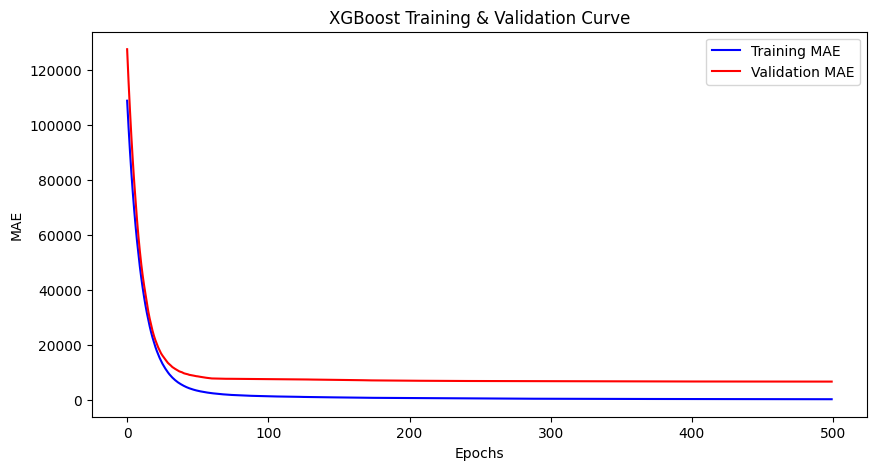

In [78]:
results = model.evals_result()

plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['mae'], label='Training MAE', color='blue')
plt.plot(results['validation_1']['mae'], label='Validation MAE', color='red')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("XGBoost Training & Validation Curve")
plt.legend()
plt.show()

In [79]:
test_sample_1 = np.array([[680, 2023]])
test_sample_1_scaled = scaler.transform(test_sample_1)
predicted_rank_1 = model.predict(test_sample_1_scaled)
print(f"Predicted Rank for 680 marks in 2023: {int(predicted_rank_1[0])}")

test_sample_2 = np.array([[450, 2022]])
test_sample_2_scaled = scaler.transform(test_sample_2)
predicted_rank_2 = model.predict(test_sample_2_scaled)
print(f"Predicted Rank for 450 marks in 2022: {int(predicted_rank_2[0])}")

Predicted Rank for 680 marks in 2023: 893
Predicted Rank for 450 marks in 2022: 128784


c:\Users\kanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\kanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
